# Analytics Vidya Hackathon Computer Vision June-2020

Team:
- Praveen Raghuvanshi
- Suman Kanukollu

### References
- [How to Train an Image Classifier in PyTorch and use it to Perform Basic Inference on Single Images](
https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5)



# Setup

In [2]:
import torch
from IPython.display import Image, clear_output 

print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.5.0+cu101 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [3]:
# Load data from Google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
cd '/content/drive/My Drive/jantahackathon/data'

/content/drive/My Drive/jantahackathon/data


In [5]:
!ls

full	jantahackathon.pth  train.csv
images	test_vc2kHdQ.csv    train_SOaYf6m.zip


# Install Extensions

In [6]:
!pip install ipython-autotime
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=67dc2fb1976f6288e20112f5c25ec976996d47f2bb9c1d94b1251345edc8a730
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


# Constants, import libraries

In [7]:
# Constants
TEST_CSV = '/content/drive/My Drive/jantahackathon/data/test_vc2kHdQ.csv'

TRAIN_CSV = '/content/drive/My Drive/jantahackathon/data/train.csv'
TOTAL_IMAGES_PATH = '/content/drive/My Drive/jantahackathon/data/full'
TOTAL_IMAGES_EMERGENCY_PATH = '/content/drive/My Drive/jantahackathon/data/full/emergency'
TOTAL_IMAGES_NOT_EMERGENCY_PATH = '/content/drive/My Drive/jantahackathon/data/full/notemergency'
TRAIN_ZIP = '/content/drive/My Drive/jantahackathon/data/train_SOaYf6m.zip'
ALL_IMAGES_PATH = '/content/drive/My Drive/jantahackathon/data/images'

time: 2.7 ms


In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from skimage.io import imread
from tqdm import tqdm

%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

time: 10.5 ms


# Preview Test CSV

In [9]:
test_dataframe = pd.read_csv(TEST_CSV)

time: 543 ms


In [10]:
test_dataframe.head()

,image_names
0,1960.jpg
1,668.jpg
2,2082.jpg
3,808.jpg
4,1907.jpg


time: 33.8 ms


In [11]:
test_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706 entries, 0 to 705
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_names  706 non-null    object
dtypes: object(1)
memory usage: 5.6+ KB
time: 7.9 ms


# Preview Train CSV

In [12]:
train_dataframe = pd.read_csv(TRAIN_CSV)

time: 778 ms


In [13]:
train_dataframe.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


time: 16.1 ms


In [14]:
train_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_names       1646 non-null   object
 1   emergency_or_not  1646 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 25.8+ KB
time: 5.26 ms


# Images

In [15]:
all_images = os.listdir(ALL_IMAGES_PATH)
print('Total images: ', len(all_images))

Total images:  2352
time: 24.9 s


In [0]:
'''import shutil 

for row in train_dataframe.itertuples():
  img_name = row.image_names
  emergency_or_not = row.emergency_or_not
  source = ALL_IMAGES_PATH + '/' + str(img_name)
  if emergency_or_not == 1:   
    destination = TRAIN_IMAGES_EMERGENCY_PATH + '/' + str(img_name)
  if emergency_or_not == 0:   
    destination = TRAIN_IMAGES_NOT_EMERGENCY_PATH + '/' + str(img_name)
  
  dest = shutil.copyfile(source, destination)
  print(dest) '''


In [16]:
print(len(os.listdir(TOTAL_IMAGES_EMERGENCY_PATH)))
print(len(os.listdir(TOTAL_IMAGES_NOT_EMERGENCY_PATH)))

681
965
time: 43.4 s


# Load Dataset

In [17]:
data_dir = TOTAL_IMAGES_PATH
def load_split_train_test(datadir, valid_size = .2):
    
    train_transforms = transforms.Compose([transforms.ToTensor(),])
    test_transforms = transforms.Compose([transforms.ToTensor(),])

    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=16)
    return trainloader, testloader

['emergency', 'notemergency']
time: 56.1 ms


In [19]:
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['emergency', 'notemergency']
time: 41.9 ms


# Display Images

In [20]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def display(noofimages, trainloader, classes):
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()
    maximagescount = labels.size()[0]
    print(maximagescount)
    print(len(images))
    if noofimages > maximagescount:
        raise ValueError('The no of images must be less than ' + maximagescount)

    # show images
    imshow(torchvision.utils.make_grid(images[:5]))

    # display labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(noofimages)))

time: 13.8 ms


## Train Samples

16
16
emergency notemergency notemergency notemergency emergency


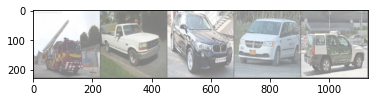

time: 8.55 s


In [21]:
# Display train samples
display(5, trainloader, trainloader.dataset.classes)

# Test Samples

16
16
notemergency emergency notemergency notemergency notemergency


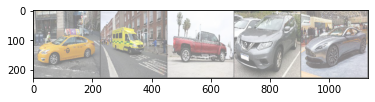

time: 7.99 s


In [22]:
# Display Test samples
display(5, testloader, testloader.dataset.classes)

# Model

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

### Freeze and modify final layer

In [25]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 2),
                                 nn.LogSoftmax(dim=1))

time: 17.8 ms


## Loss and Optimizer

In [26]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

time: 9.49 s


## Training - Train

In [27]:
epochs = 10
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in tqdm(range(epochs)):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'jantahackathon.pth')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10.. Train loss: 2.007.. Test loss: 1.999.. Test accuracy: 0.391
Epoch 1/10.. Train loss: 0.980.. Test loss: 0.474.. Test accuracy: 0.783
Epoch 1/10.. Train loss: 0.529.. Test loss: 0.300.. Test accuracy: 0.876
Epoch 1/10.. Train loss: 0.336.. Test loss: 0.464.. Test accuracy: 0.816
Epoch 1/10.. Train loss: 0.424.. Test loss: 0.804.. Test accuracy: 0.582
Epoch 1/10.. Train loss: 0.400.. Test loss: 0.389.. Test accuracy: 0.858
Epoch 1/10.. Train loss: 0.292.. Test loss: 0.251.. Test accuracy: 0.911
Epoch 1/10.. Train loss: 0.293.. Test loss: 0.241.. Test accuracy: 0.917


 10%|█         | 1/10 [13:32<2:01:50, 812.24s/it]

Epoch 2/10.. Train loss: 0.260.. Test loss: 0.258.. Test accuracy: 0.905
Epoch 2/10.. Train loss: 0.212.. Test loss: 0.254.. Test accuracy: 0.882
Epoch 2/10.. Train loss: 0.275.. Test loss: 0.240.. Test accuracy: 0.896
Epoch 2/10.. Train loss: 0.250.. Test loss: 0.255.. Test accuracy: 0.905
Epoch 2/10.. Train loss: 0.274.. Test loss: 0.240.. Test accuracy: 0.914
Epoch 2/10.. Train loss: 0.281.. Test loss: 0.251.. Test accuracy: 0.885
Epoch 2/10.. Train loss: 0.298.. Test loss: 0.250.. Test accuracy: 0.911
Epoch 2/10.. Train loss: 0.224.. Test loss: 0.241.. Test accuracy: 0.897


 20%|██        | 2/10 [13:51<1:16:34, 574.25s/it]

Epoch 3/10.. Train loss: 0.290.. Test loss: 0.510.. Test accuracy: 0.841
Epoch 3/10.. Train loss: 0.392.. Test loss: 0.235.. Test accuracy: 0.917
Epoch 3/10.. Train loss: 0.213.. Test loss: 0.229.. Test accuracy: 0.911
Epoch 3/10.. Train loss: 0.227.. Test loss: 0.319.. Test accuracy: 0.864
Epoch 3/10.. Train loss: 0.262.. Test loss: 0.262.. Test accuracy: 0.912
Epoch 3/10.. Train loss: 0.284.. Test loss: 0.263.. Test accuracy: 0.905
Epoch 3/10.. Train loss: 0.277.. Test loss: 0.228.. Test accuracy: 0.914
Epoch 3/10.. Train loss: 0.117.. Test loss: 0.244.. Test accuracy: 0.911


 30%|███       | 3/10 [14:10<47:33, 407.68s/it]  

Epoch 4/10.. Train loss: 0.244.. Test loss: 0.314.. Test accuracy: 0.872
Epoch 4/10.. Train loss: 0.207.. Test loss: 0.230.. Test accuracy: 0.899
Epoch 4/10.. Train loss: 0.196.. Test loss: 0.322.. Test accuracy: 0.902
Epoch 4/10.. Train loss: 0.243.. Test loss: 0.238.. Test accuracy: 0.903
Epoch 4/10.. Train loss: 0.212.. Test loss: 0.243.. Test accuracy: 0.920
Epoch 4/10.. Train loss: 0.246.. Test loss: 0.223.. Test accuracy: 0.905
Epoch 4/10.. Train loss: 0.198.. Test loss: 0.237.. Test accuracy: 0.902
Epoch 4/10.. Train loss: 0.226.. Test loss: 0.288.. Test accuracy: 0.902


 40%|████      | 4/10 [14:31<29:10, 291.70s/it]

Epoch 4/10.. Train loss: 0.309.. Test loss: 0.221.. Test accuracy: 0.912
Epoch 5/10.. Train loss: 0.199.. Test loss: 0.214.. Test accuracy: 0.920
Epoch 5/10.. Train loss: 0.245.. Test loss: 0.282.. Test accuracy: 0.905
Epoch 5/10.. Train loss: 0.223.. Test loss: 0.231.. Test accuracy: 0.920
Epoch 5/10.. Train loss: 0.271.. Test loss: 0.241.. Test accuracy: 0.909
Epoch 5/10.. Train loss: 0.222.. Test loss: 0.281.. Test accuracy: 0.882
Epoch 5/10.. Train loss: 0.163.. Test loss: 0.282.. Test accuracy: 0.905
Epoch 5/10.. Train loss: 0.273.. Test loss: 0.230.. Test accuracy: 0.914
Epoch 5/10.. Train loss: 0.309.. Test loss: 0.400.. Test accuracy: 0.808


 50%|█████     | 5/10 [14:50<17:29, 209.95s/it]

Epoch 6/10.. Train loss: 0.260.. Test loss: 0.300.. Test accuracy: 0.896
Epoch 6/10.. Train loss: 0.256.. Test loss: 0.231.. Test accuracy: 0.920
Epoch 6/10.. Train loss: 0.218.. Test loss: 0.244.. Test accuracy: 0.905
Epoch 6/10.. Train loss: 0.216.. Test loss: 0.212.. Test accuracy: 0.911
Epoch 6/10.. Train loss: 0.159.. Test loss: 0.263.. Test accuracy: 0.906
Epoch 6/10.. Train loss: 0.222.. Test loss: 0.219.. Test accuracy: 0.908
Epoch 6/10.. Train loss: 0.285.. Test loss: 0.530.. Test accuracy: 0.828
Epoch 6/10.. Train loss: 0.277.. Test loss: 0.214.. Test accuracy: 0.926


 60%|██████    | 6/10 [15:09<10:10, 152.64s/it]

Epoch 7/10.. Train loss: 0.176.. Test loss: 0.215.. Test accuracy: 0.923
Epoch 7/10.. Train loss: 0.180.. Test loss: 0.240.. Test accuracy: 0.914
Epoch 7/10.. Train loss: 0.279.. Test loss: 0.224.. Test accuracy: 0.920
Epoch 7/10.. Train loss: 0.311.. Test loss: 0.354.. Test accuracy: 0.858
Epoch 7/10.. Train loss: 0.289.. Test loss: 0.224.. Test accuracy: 0.915
Epoch 7/10.. Train loss: 0.211.. Test loss: 0.220.. Test accuracy: 0.923
Epoch 7/10.. Train loss: 0.347.. Test loss: 0.219.. Test accuracy: 0.929
Epoch 7/10.. Train loss: 0.254.. Test loss: 0.313.. Test accuracy: 0.876


 70%|███████   | 7/10 [15:29<05:38, 112.99s/it]

Epoch 7/10.. Train loss: 0.212.. Test loss: 0.291.. Test accuracy: 0.870
Epoch 8/10.. Train loss: 0.188.. Test loss: 0.215.. Test accuracy: 0.929
Epoch 8/10.. Train loss: 0.170.. Test loss: 0.222.. Test accuracy: 0.920
Epoch 8/10.. Train loss: 0.197.. Test loss: 0.270.. Test accuracy: 0.908
Epoch 8/10.. Train loss: 0.177.. Test loss: 0.268.. Test accuracy: 0.914
Epoch 8/10.. Train loss: 0.281.. Test loss: 0.211.. Test accuracy: 0.914
Epoch 8/10.. Train loss: 0.330.. Test loss: 0.254.. Test accuracy: 0.888
Epoch 8/10.. Train loss: 0.234.. Test loss: 0.227.. Test accuracy: 0.912
Epoch 8/10.. Train loss: 0.208.. Test loss: 0.217.. Test accuracy: 0.917


 80%|████████  | 8/10 [15:49<02:49, 84.92s/it] 

Epoch 9/10.. Train loss: 0.222.. Test loss: 0.373.. Test accuracy: 0.822
Epoch 9/10.. Train loss: 0.293.. Test loss: 0.301.. Test accuracy: 0.899
Epoch 9/10.. Train loss: 0.152.. Test loss: 0.226.. Test accuracy: 0.912
Epoch 9/10.. Train loss: 0.312.. Test loss: 0.201.. Test accuracy: 0.932
Epoch 9/10.. Train loss: 0.177.. Test loss: 0.222.. Test accuracy: 0.921
Epoch 9/10.. Train loss: 0.150.. Test loss: 0.209.. Test accuracy: 0.918
Epoch 9/10.. Train loss: 0.257.. Test loss: 0.251.. Test accuracy: 0.912
Epoch 9/10.. Train loss: 0.318.. Test loss: 0.219.. Test accuracy: 0.909


 90%|█████████ | 9/10 [16:08<01:05, 65.09s/it]

Epoch 10/10.. Train loss: 0.308.. Test loss: 0.209.. Test accuracy: 0.923
Epoch 10/10.. Train loss: 0.249.. Test loss: 0.234.. Test accuracy: 0.905
Epoch 10/10.. Train loss: 0.169.. Test loss: 0.218.. Test accuracy: 0.920
Epoch 10/10.. Train loss: 0.207.. Test loss: 0.244.. Test accuracy: 0.920
Epoch 10/10.. Train loss: 0.213.. Test loss: 0.218.. Test accuracy: 0.910
Epoch 10/10.. Train loss: 0.162.. Test loss: 0.207.. Test accuracy: 0.932
Epoch 10/10.. Train loss: 0.268.. Test loss: 0.195.. Test accuracy: 0.926
Epoch 10/10.. Train loss: 0.167.. Test loss: 0.196.. Test accuracy: 0.923


100%|██████████| 10/10 [16:28<00:00, 98.86s/it]

Epoch 10/10.. Train loss: 0.146.. Test loss: 0.217.. Test accuracy: 0.924


time: 16min 33s


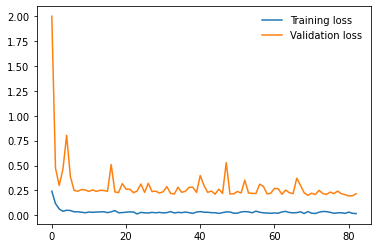

time: 199 ms


In [28]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

### Evaluation - Test

In [29]:
data_dir = TOTAL_IMAGES_PATH

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406],
                                      #                     [0.229, 0.224, 0.225])
                                     ])

time: 1.92 ms


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('jantahackathon.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

time: 299 ms


In [31]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

time: 3.94 ms


In [32]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

time: 6.04 ms


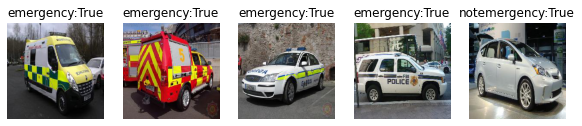

time: 404 ms


In [33]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(testloader.dataset.classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [0]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 8, kernel_size=3, stride=1, padding=1), # 224 -> 222
            BatchNorm2d(8),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),                 # 222 -> 111

            # Defining another 2D convolution layer
            Conv2d(8, 16, kernel_size=3, stride=1, padding=1), # 111 -> 109
            BatchNorm2d(16),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),                  # 109 -> 54

            # Defining another 2D convolution layer
            Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # 54 -> 52
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),                  # 52 -> 27

            # Defining another 2D convolution layer
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1), # 27 -> 25
            BatchNorm2d(128),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),                  # 25 -> 12

            # Defining another 2D convolution layer
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1), # 12 -> 10
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),                  # 10 -> 5
        )

        self.linear_layers = Sequential(
            Linear(4 * 5 * 5, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [0]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, 

In [0]:
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

In [0]:
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()